In [1]:
import os, cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from helpers import *

In [ ]:
os.environ["OPENAI_API_KEY"] = "" # Insert your OpenAI API key

In [3]:
# 1. Load image
image_path = Path('data/0.jpg')
image = cv2.imread(str(image_path))

# 2. Load nodes and edges data
# edges
edges_path = Path('data/0_refined_edges_dict.pkl')
edges_dict = load_pickle(edges_path)

# nodes
nodes_path = Path('data/0_refined_nodes_dict.pkl')
nodes_dict = load_pickle(nodes_path)


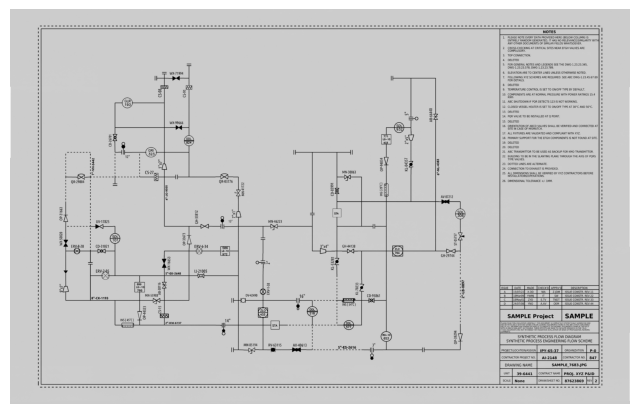

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(image)
ax.axis('off')
plt.show()

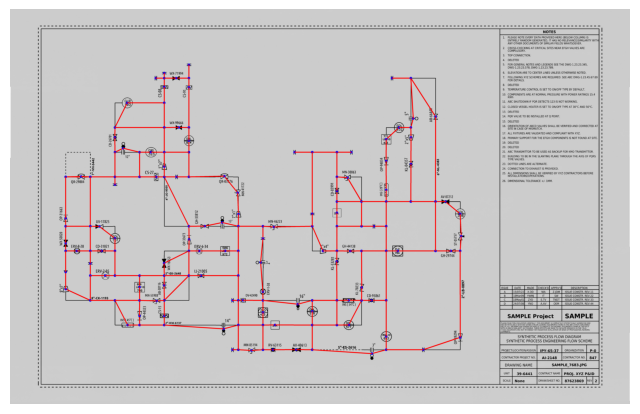

In [5]:
for edge, node_pair in edges_dict.items():
    node_1, node_2 = node_pair
    x1, y1 = node_center(node_1, nodes_dict)
    x2, y2 = node_center(node_2, nodes_dict)
    # draw nodes as blue circles
    cv2.circle(image, (int(x1), int(y1)), 15, (0, 0, 255), -1)
    cv2.circle(image, (int(x2), int(y2)), 15, (0, 0, 255), -1)
    # draw edges as red lines
    cv2.line(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 10)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(image)
ax.axis('off')
plt.show()

### Creating a *geomterically aligned* graph in Networkx

In [6]:
import networkx as nx

Number of nodes: 161
Number of edges: 205


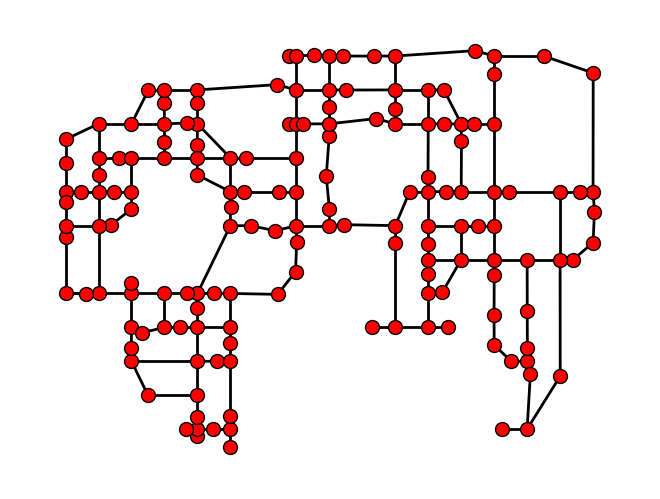

In [7]:
G = nx.Graph()
nodes_to_add = []
pos = {} # node positions
for edge, node_pair in edges_dict.items():
    for node in node_pair:
        if node not in nodes_to_add:
            G.add_node(node)
            pos[node] = node_center(node, nodes_dict)
            nodes_to_add.append(node)
    G.add_edge(node_pair[0], node_pair[1])

# Print some graph information
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

# Plot the graph
options = {
    "font_size": 36,
    "node_size": 100,
    "node_color": "red",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 2,
}

nx.draw(G, pos, with_labels=False, font_weight='bold', **options)

### Creating Graphs in Neo4j

In [9]:
from neo4j import GraphDatabase

In [13]:
# Step-1: make connection to database
# database credentials
uri = "bolt://localhost:7687"
auth = ("neo4j", "password")
data_base_connection = GraphDatabase.driver(uri = uri, auth=auth) 
pidKG = data_base_connection.session() 

# Step-2: create nodes
nodes_to_add = []
for edge, node_pair in edges_dict.items():
    for node in node_pair:
        if node not in nodes_to_add:
            if node.startswith('J'):
                node_type = 'Junction'
            else:
                node_type = 'Symbol'
            center_x, center_y = node_center(node, nodes_dict)
            _, class_name, tag = nodes_dict[node]
            pidKG.run(
                f"CREATE (n:{node_type} {{class: {class_name}, tag: '{tag}', center_x: {center_x}, center_y: {center_y}, alias: '{node}'}})"
            )
            nodes_to_add.append(node)
        #     session.run(
        #     "CREATE (j:{node_type} {class: $j_name, tag: $j_tag, center_x: $j_location_x, center_y: $j_location_y, alias: $j_alias})",
        #     j_name = node_classname, j_tag=node_tag, j_location_x=node_location[0], j_location_y=node_location[1], j_alias=node_alias
        # )

# Step-3: create edges
# Note: this step could be combined with the Step-2. But there can be chances that some nodes are not created and
# we are trying to create edges between them. So, it is better to create nodes first and then create edges.

for edge, node_pair in edges_dict.items():
    node1, node2 = node_pair
    pidKG.run(
        "MATCH (n1), (n2) WHERE n1.alias = $n1_alias AND n2.alias = $n2_alias CREATE (n1)-[:CONNECTED_TO]->(n2)",
        n1_alias=node1, n2_alias=node2
    )

# Note: directions above are arbitrary because arrows are not shown on the given P&ID. 
# However, Neo4j requires a direction for each edge so we have chosen an arbitrary direction.
# In later stage, when querying into the Graph, we can ignore the direction of the edge.

If the above steps are followed, a graph looking something similar to what is shown below will get populated on `Neo4j` Desktop

<img src="media/KG_neo4j.png" width="600" height="600">

### Develop QA system (RAG on Graph)

In [20]:
from langchain_community.graphs import Neo4jGraph #-> Old but works # New: from langchain_neo4j import Neo4jGraph (I found new to be troublesome for me)
from langchain_chroma import Chroma
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import OpenAIEmbeddings

In [16]:

######################################################
# Connect Neo4j graph with langchain to extract schema
######################################################
graph = Neo4jGraph(
    url=uri,
    username=auth[0],
    password=auth[1],
    enhanced_schema=True,
)

# print graph schema that we will be using as "context" to guide LLM
graph.refresh_schema()
pidKG_schema = graph.schema
print(pidKG_schema)

C:\Users\mgupta70\AppData\Local\Temp\ipykernel_22632\1859104695.py:4: LangChainDeprecationWarning: The class `Neo4jGraph` was deprecated in LangChain 0.3.8 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-neo4j package and should be used instead. To use it run `pip install -U :class:`~langchain-neo4j` and import as `from :class:`~langchain_neo4j import Neo4jGraph``.
  graph = Neo4jGraph(
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] 

Node properties:
- **Symbol**
  - `alias`: STRING Example: "symbol_11"
  - `center_x`: INTEGER Min: 643, Max: 5216
  - `center_y`: INTEGER Min: 644, Max: 3979
  - `class`: INTEGER Min: 1, Max: 32
  - `tag`: STRING Example: "SDL 101"
- **Junction**
  - `alias`: STRING Example: "J57"
  - `center_x`: INTEGER Min: 643, Max: 5204
  - `center_y`: INTEGER Min: 798, Max: 3934
  - `class`: INTEGER Min: -999, Max: -999
  - `tag`: STRING Example: "line_NN_515-line_NN_645"
Relationship properties:

The relationships:
(:Symbol)-[:CONNECTED_TO]->(:Symbol)
(:Symbol)-[:CONNECTED_TO]->(:Junction)
(:Junction)-[:CONNECTED_TO]->(:Symbol)
(:Junction)-[:CONNECTED_TO]->(:Junction)


In [21]:

examples = [
    {
        "question": "Count the symbols with class 16 that are directly linked to symbols with class 25",
        "query": """MATCH (s1:Symbol {{class: 16}})-[:CONNECTED_TO]-(s2:Symbol {{class: 25}}) RETURN COUNT(s1)"""
    },
    {
        "question": "What is the number of symbols with class 18 that have direct connections to symbols with class 4?",
        "query": "MATCH (s1:Symbol {{class: 18}})-[:CONNECTED_TO]-(s2:Symbol {{class: 4}}) RETURN COUNT(s1)"
    },
    {
        "question": "Count the number of 10 symbols that are directly connected to 18 symbols",
        "query": "MATCH (s1:Symbol {{class: 10}})-[:CONNECTED_TO]-(s2:Symbol {{class: 18}}) RETURN COUNT(s1)"
    }, 
    {
        "question":"How many items fall into the 18 classification?",
        "query": "MATCH (s:Symbol) WHERE s.class = 18 RETURN count(s)"
    },
    {
        "question":"Could you determine the total count of symbols of type 23?",
        "query": "MATCH (s:Symbol) WHERE s.class = 23 RETURN count(s)"
    },
    {
        "question":"What’s the number of entities in class 7?",
        "query": "MATCH (s:Symbol) WHERE s.class = 7 RETURN count(s)"
    },
    {
        "question":"Enumerate distinct symbols of class 32",
        "query": "MATCH (s:Symbol) WHERE s.class = 32 RETURN count(s)"
    },
    {
        "question":"Give the number of symbols listed under 11?",
        "query": "MATCH (s:Symbol) WHERE s.class = 11 RETURN count(s)"
    },
    {
        "question":"How many elements in class 21 are directly associated with elements in class 5?",
        "query": "MATCH (s1:Symbol)-[:CONNECTED_TO]-(s2:Symbol) WHERE s1.class = 21 AND s2.class = 5 RETURN COUNT(s1)"
    },
    {
        "question":"What’s the total number of 11 symbols connected to 7 symbols?",
        "query": "MATCH (s1:Symbol)-[:CONNECTED_TO]-(s2:Symbol) WHERE s1.class = 11 AND s2.class = 7 RETURN COUNT(s1)"
    },
    {
        "question":"How many entities belonging to 16 are linked directly to entities in 7?",
        "query": "MATCH (s1:Symbol)-[:CONNECTED_TO]-(s2:Symbol) WHERE s1.class = 16 AND s2.class = 7 RETURN COUNT(s1)"
    },
    {
        "question":"Can you provide the count of 31-class symbols connected directly to 28-class symbols?",
        "query": "MATCH (s1:Symbol)-[:CONNECTED_TO]-(s2:Symbol) WHERE s1.class = 31 AND s2.class = 28 RETURN COUNT(s1)"
    },
    {
        "question":"What’s the number of direct links between symbols of class 23 and class 5?",
        "query": "MATCH (s1:Symbol)-[:CONNECTED_TO]-(s2:Symbol) WHERE s1.class = 23 AND s2.class = 5 RETURN COUNT(s1)"
    },
    {
        "question":"Are there any symbols classified as 1 positioned between symbols of classes 2 and 3?",
        "query": "MATCH (s1:Symbol)-[:CONNECTED_TO]-(s2:Symbol)-[:CONNECTED_TO]-(s3:Symbol) WHERE s1.class = 2 AND s2.class = 1 AND s3.class = 7 RETURN COUNT(s2) > 0"
    },
    {
        "question":"Could you check if a symbol of class 8 serves as a link between class 19 and class 13?",
        "query": "MATCH (s1:Symbol)-[:CONNECTED_TO]-(s2:Symbol)-[:CONNECTED_TO]-(s3:Symbol) WHERE s1.class = 19 AND s2.class = 8 AND s3.class = 13 RETURN COUNT(s2) > 0"
    },
    {
        "question":"Can you find any symbol in class 21 that connects symbols of classes 8 and 10 at the same time?",
        "query": "MATCH (s1:Symbol)-[:CONNECTED_TO]-(s2:Symbol)-[:CONNECTED_TO]-(s3:Symbol) WHERE s1.class = 8 AND s2.class = 21 AND s3.class = 10 RETURN COUNT(s2) > 0"
    },
    {
        "question":"Can you determine if symbols of class 10 are situated between those of class 4 and class 12?",
        "query": "MATCH (s1:Symbol)-[:CONNECTED_TO]-(s2:Symbol)-[:CONNECTED_TO]-(s3:Symbol) WHERE s1.class = 4 AND s2.class = 10 AND s3.class = 12 RETURN COUNT(s2) > 0"
    },
    {
        "question":"Is it possible to identify symbols in class 29 on one side and class 17 on another side of class 25 symbol?",
        "query": "MATCH (s1:Symbol)-[:CONNECTED_TO]-(s2:Symbol)-[:CONNECTED_TO]-(s3:Symbol) WHERE s1.class = 29 AND s2.class = 25 AND s3.class = 17 RETURN COUNT(s2) > 0"
    },
    {
        "question":"Can you provide a list of tags for symbols in class 8 where the tags start with ZX?",
        "query": "MATCH (s:Symbol)WHERE s.class = 8 AND s.tag STARTS WITH 'ZX' RETURN s.tag"
    },
    {
        "question":"What are all the tags of class 7 symbols that have QW as their prefix?",
        "query": "MATCH (s:Symbol) WHERE s.class = 7 AND s.tag STARTS WITH 'QW' RETURN s.tag"
    },
    {
        "question":"Could you list the tags for class 22 symbols that begin with the string YKX?",
        "query": "MATCH (s:Symbol) WHERE s.class = 22 AND s.tag STARTS WITH 'YKX' RETURN s.tag"
    },
    {
        "question":"Fetch the tags of 28 symbols where each tag starts with the prefix MS.",
        "query": "MATCH (s:Symbol) WHERE s.class = 28 AND s.tag STARTS WITH 'MS' RETURN s.tag"
    },
    {
        "question":"Can you return the tags of all class 14 symbols that start with FU as their prefix?",
        "query": "MATCH (s:Symbol) WHERE s.class = 14 AND s.tag STARTS WITH 'FU' RETURN s.tag"
    }

]

In [22]:
questions = ["What is total number of class 10 symbols?", "How many 10 with 2?"]

# No graph schema
cypher_generating_model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.0) # most-deterministic 


pidKG_schema = ''' Node properties:
- **Junction**
  - `alias`: STRING Example: "J55"
  - `tag`: STRING Example: "line_NN_513-line_NN_713"
  - `class`: INTEGER Min: -999, Max: -999
  - `center_x`: INTEGER Min: 643, Max: 5204
  - `center_y`: INTEGER Min: 798, Max: 3934
- **Symbol**
  - `alias`: STRING Example: "symbol_20"
  - `tag`: STRING Example: "OP-39294"
  - `class`: INTEGER Min: 1, Max: 32
  - `center_x`: INTEGER Min: 643, Max: 5216
  - `center_y`: INTEGER Min: 644, Max: 3979
Relationship properties:

The relationships:
(:Junction)-[:CONNECTED_TO]->(:Junction)
(:Junction)-[:CONNECTED_TO]->(:Symbol)
(:Symbol)-[:CONNECTED_TO]->(:Symbol)
(:Symbol)-[:CONNECTED_TO]->(:Junction)

Important Note - in graph, even though there are directions, the relationships are bidirectional.

'''

system_prompt_for_generating_cypher = f'''You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run. 
Here is the schema information for the underlying graph database: {pidKG_schema}.
Don't add any preambles, just return the correct cypher query with no further commentary.
Output the final Cypher query only.'''

example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples, # examples to select from
    OpenAIEmbeddings(), # embedding class to produce embeddings to measure semantic similarity.
    Chroma, # VectorStore class that is used to store the embeddings
    k=2, # number of examples to produce.

)

for q in questions:
    selected_fewshot_examples = example_selector.select_examples({"question": q})
    
    messages = [SystemMessage(f"{system_prompt_for_generating_cypher}"),
                SystemMessage(f"Here is few examples of questions and their corresponding Cypher queries: {selected_fewshot_examples}."),
                HumanMessage(f"{q}")]
    cypher_generated = cypher_generating_model(messages).content #.strip()
    print(cypher_generated)
    print('')
    


C:\Users\mgupta70\AppData\Local\Temp\ipykernel_22632\2531606150.py:51: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  cypher_generated = cypher_generating_model(messages).content #.strip()


MATCH (s:Symbol) WHERE s.class = 10 RETURN count(s)

MATCH (s1:Symbol {class: 10})-[:CONNECTED_TO]-(s2:Symbol {class: 2})
RETURN COUNT(s1)



In [33]:
def run_query(query, session):
    result = session.run(query)
    return [record for record in result]

In [ ]:
res = run_query(cypher_generated, pidKG)
for record in res:
    print(record)